In [1]:
import tweepy
from tweepy import OAuthHandler
import pickle as p
import re
import json
from collections import defaultdict
import random
from numpy import arange, where, isin, mean, array, exp, sqrt, dot, pi, diag, concatenate
from bs4 import BeautifulSoup
import requests
from scipy.optimize import curve_fit
from random import uniform
from numpy.random import normal
from matplotlib.pyplot import hist, show, plot, xlim, legend
from datetime import datetime

# Collect Trump's Tweets 

In [39]:
twitter_keys=p.load(open('tk.pkl','rb'))

In [40]:

 
auth = OAuthHandler(twitter_keys['consumer_key'], twitter_keys['consumer_secret'])
auth.set_access_token(twitter_keys['access_token'], twitter_keys['access_secret'])
 
api = tweepy.API(auth)

In [41]:
def limit_handled(cursor):
    while True:
        try:
            yield cursor.next()
        except tweepy.RateLimitError:
            time.sleep(15 * 60)
            

In [42]:
hold=[]
with open('test.txt','w') as f:
    json.dump([], f)
for i,status in enumerate(limit_handled(tweepy.Cursor(api.user_timeline,'realDonaldTrump').items(10000))):
    hold.append(status._json)
    if i%100==0:
        with open('test.txt','r') as f:
            a=json.load(f)+hold
        with open('test.txt','w') as f:
            json.dump(a, f)
        hold=[]

In [43]:
trump_tweets=json.load(open('test.txt','r'))

In [44]:
len(trump_tweets)

3201

# Trump Tweet Times 

### Tweets per day

In [37]:
str(datetime.now())[:10]

'2017-11-26'

In [34]:
convert_time(str(datetime.now())[11:19])


15.264722222222222

In [3]:
def tweets_per_day(tweets):
    daily_tweets=defaultdict(list)
    j=0
    day = tweets[0]['created_at'][:3]
    for i,t in enumerate(tweets[:-1]):
        next_day=tweets[i+1]['created_at'][:3]
        j+=1
        if day!=next_day:
            daily_tweets[day].append(j)
            day=next_day
            j=0
    if j!=0:
        j+=1
        daily_tweets[day].append(j)
    else:
        daily_tweets[next_day].append(1)
    return daily_tweets

In [4]:
dt = tweets_per_day(trump_tweets)

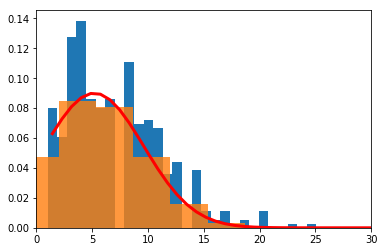

In [5]:
counts,bounds,_ = hist([i for v in dt.values() for i in v],bins=100,normed=True)
bin_c=(bounds[1:]+bounds[:-1])/2

def gauss(x,mu,sigma):
    return exp(-(x-mu)**2/2/sigma**2)/sqrt(2*pi*sigma**2)

expected=(10,4)
params,cov=curve_fit(gauss,bin_c,counts,expected)
plot(bin_c,gauss(bin_c,*params),color='red',lw=3,label='model')

g1 = normal(params[0],params[1],int(round(len(counts)*100)))
counts1,bounds1,_=hist(g1,alpha=.8,normed=True)
xlim(0,30)
show()

In [6]:
tweets_per_day=0
while tweets_per_day <=0:
    tweets_per_day=int(round(normal(params[0],params[1])))
tweets_per_day

9

In [7]:
def convert_time(t):
    return int(t[:2])+int(t[3:5])/60+int(t[6:8])/3600
    

def tweet_times(tweets):
    times=[]
    for t in tweets:
        created_at = t['created_at']
        col_loc=where([v==':' for v in created_at])[0][0]
        times.append(convert_time(created_at[col_loc-2:col_loc+6]))
    return array(times)

In [8]:
times=tweet_times(trump_tweets)-7
for i,t in enumerate(times):
    if t<0:
        times[i]+=24
        

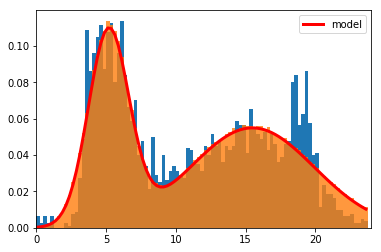

In [9]:
counts,bounds,_=hist(times,bins=arange(0,24,.25),normed=True)
bin_c=(bounds[1:]+bounds[:-1])/2

def bimodal(x,mu1,sigma1,w1,mu2,sigma2):
    return w1*gauss(x,mu1,sigma1)+(1-w1)*gauss(x,mu2,sigma2)

expected=(5,1,.1,15,5)
params,cov=curve_fit(bimodal,bin_c,counts,expected)
plot(bin_c,bimodal(bin_c,*params),color='red',lw=3,label='model')

g1 = normal(params[0],params[1],int(round(params[2]*len(times)*100)))
g2 = normal(params[3],params[4],int(round((1-params[2])*len(times)*100)))
gg=concatenate((g1,g2))
counts1,bounds1,_=hist(gg,bins=arange(0,24,.25),alpha=.8,normed=True)

xlim(0,24)
legend()
show()
#xlim(0,24)

# Generate Times 

In [10]:
times=[]
for i in arange(tweets_per_day):
    time=25
    while (time<0 or time>24):
        if uniform(0,1) >= params[2]:
            time = normal(params[3],params[4])
        else:
            time = normal(params[0],params[1])
        time+=7
        if time>24: time-=24
    times.append(time)
print(times)

[11.585621519191676, 9.965475420313746, 12.775507281731624, 16.31557327668036, 8.961376293274185, 3.1271418346760775, 1.4725994402521003, 18.607300285828277, 19.419581502811997]


# Filter tweets into strings 

In [11]:
def drop_links(tweet_words):
    try:
        cutoff=where([x=='https' for x in tweet_words])[0][0]
        return tweet_words[:cutoff]
    except IndexError:
        return tweet_words

def grab_links(tweet_list):
    if 'http' in tweet_list[-1]:
        return tweet_list[-1]
    else:
        return ''
    
def fix_symbols(words):
    for i,w in enumerate(words):
        if w =='amp':
            words[i]='&'
            del words[i+1]
        if w =='U' and words[i+1:i+6]==['.','S','.','A','.']:
            words[i]='U.S.A.'
            del words[i+1:i+6]
    return words



In [12]:
def tweets_to_list(tweets):
    tweet_words=[]
    for tweet in tweets:
        if tweet['text'][:2]!='RT':# and not tweet['truncated']:
            link=grab_links(tweet['text'].split())
            tweet_words.extend(drop_links(re.findall(r"[\w']+|[.,!?;]",tweet['text']))+[link])
    return fix_symbols(tweet_words)

In [13]:
trump_words=tweets_to_list(trump_tweets)


# Generate New Tweets 

In [14]:
def generate_using_nxmgrams(n,m,words):
    '''
    Generate a sentence using the ngrams method. 
    
    Params:
    n: Words is broken into seqences of length n, n-1 words are then used to predict the next word.
    words: A list of words that generated sentences will be based on.
    '''
    
    if not n>1:raise ValueError("n must be at least 2")
        
    nxmgrams=zip(*[words[i:] for i in arange(n+m)])
    transitions=defaultdict(list)
    starts=[]
    
    for nxmgram in nxmgrams:
        if nxmgram[0] in ['.','!','?']:
            starts.append(nxmgram[1:-m])
        transitions[nxmgram[:-m]].append(nxmgram[-m:])
    
    current= random.choice(starts)
    prev='.'
    result=[*current]
    while True:
        next_candidates=transitions[(prev,*current)]
        next = random.choice(next_candidates)
        prev = current[m-n]
        if n-1-m==0:
            current = (*next,)
        else:
            current =  current[m+1-n:]+(*next,)
        for c in current[-m:]: result.append(c)
        if current[-1] in ['.','!','?'] and len(result)>5: return ' '.join(result)

In [68]:
gen_tweet=['.','.','.','.','.']
while gen_tweet.count('.')>4:
    try:
        gen_tweet=generate_using_nxmgrams(3,1,trump_words)
    except IndexError:
        gen_tweet[:3]==['.','.','.','.','.']
print(gen_tweet)

WIN !  In all fairness to Anthony Scaramucci , he wanted to endorse me 1st , before the Republican Primaries started , but didn't think I was running !


# Scrape Fox News for Headlines 

In [50]:
url="http://www.foxnews.com"
html=requests.get(url).text
soup=BeautifulSoup(html,'html5lib')

In [51]:
stories=soup.find_all('h2',{'class':['title']})

In [52]:
headlines=[story.a.contents[0] for story in stories if 'video' not in story.a.get('href')]


In [53]:
headlines

['Former staffer: Embattled Rep. Conyers took meeting wearing only underwear',
 'WaPo reporter caught plotting Dem strategy with Soros',
 "Linda Tripp not buying Dems' newfound scorn for Clinton",
 'Hunter shoots, kills woman walking dogs after mistaking her for deer',
 'Hackers putting pornographic images on ISIS propaganda sites, report says',
 "Judge rules Seattle's tax on the wealthy is illegal; city vows to appeal",
 "'Let it Go' singers Demi Lovato, Idina Menzel sued by man claiming hit ripped off song",
 'Mark Levin on cable news rivals: ‘We’ll actually have an audience’',
 'Trump rips NY Giants player who took a knee on Thanksgiving',
 'Incredible 1,500-year-old Christian mosaic uncovered in Israel',
 'Scientists discover dazzling blue tarantula in South America',
 "Arpaio pursued case against Sen. Jeff Flake's son for political reasons, lawsuit claims",
 "Saudi Arabia's crown prince calls Iran's supreme leader 'new Hitler' of the Middle East",
 "Philadelphia mayor unloads on T